In [248]:
import matplotlib.pyplot as plt
import numpy as np

In [249]:
# Mean squared error from residual
def mse_from_e(residual):
    #ACT1: MSE from residual
    
    # residual = y - y_hat
    error = residual**2
    mse = np.sum(error)/len(residual)
    return mse

    
# Mean Squared Error of X.w - y
def mean_squared_error(X, y_vec, w):
    #ACT2: MSE for generator"
    
    # y_hat = (each row of X) * w
    # e = y_hat - y
    # y-vector is generated, loop through each value to compare against predicted
    error = [(np.dot(row,w)-y[0])**2 for row,y in zip(X[:],y_vec)]
    mse = np.sum(error)/len(y_vec)

    return mse

#CHECKS
assert(mse_from_e(np.array([2,-3,1,-2]))==4.5)
assert(mean_squared_error(np.array([[1,0,1],[0,0,1],[1,1,1]]), np.array([[0],[1],[0]]), np.array([1,1,1]))==(13/3))
    

In [250]:
# Generate a sawtooth weight vector
def genu(d, m):
    u = np.arange(d) * (2 * (np.arange(d) % 2) - 1)
    u = m * u / np.sqrt(np.dot(u, u))
    return u

# Generate random data
def genx(n, d):
    X = np.random.randint(0, 2, (n, d))
    X[:,int(d/2)] = 1
    return X

# Generate targets and add noise
def gent(X, u, noise):
    n = X.shape[0]
    y = np.dot(X, u).reshape(n, 1)
    y += noise * np.var(y) * np.random.randn(n, 1)
    return y

# Generate data, weights, and targets
def gimme_data_regres(n, d, noise=0.1):
    u = genu(d, 1.0)
    X = genx(n, d)
    y = gent(X, u, noise)
    mse_gen = mean_squared_error(X, y, u)
    print('Generator Loss={0:8.5f}\n'.format(mse_gen))
    return X, u, y

In [251]:
# Plot loss as a function of epoch
def loss_plotter(vlist, fname):
    vr = vlist[0]
    vn = vlist[1]
    plt.plot(range(1, 1+len(vr)), vr,
           range(1, 1+len(vn)), vn,
           linewidth=2, linestyle='-', marker='o')
    plt.legend(('rep', 'nor'))
    plt.grid()
    xt = np.arange(1, 1 + max(len(vr), len(vn)))
    _ = plt.xticks(xt)
    _ = plt.xlabel('Epoch', fontsize=14)
    _ = plt.ylabel(fname, fontsize=14)
    plt.show()
    return

# Scatter plot of predicted vs. observed targets
def loss_scatter(X, y, w, fname):
    plt.scatter(y, X.dot(w), edgecolors=(0,0,0))
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.grid()
    plt.xlabel('$y$', fontsize=14)
    plt.ylabel('$\hat{y}$', fontsize=14)
    plt.show()

In [252]:
# sample new index (w/ or w/o replacement)
def sample_new_index(d, replace=1):
    if replace:
        #ACT3: Sample with Replacement
        ind = np.random.choice(d, 1) #Choose random column from number of features  
    else:
        #ACT4: Sample without Replacement
        
        #Trigger this only at the beginning of an epoch, create new list without replacement
        if 'prm' not in sample_new_index.__dict__:
            sample_new_index.prm = np.random.permutation(d)
            sample_new_index.head = 0
        
        #Select the next column index from generated list, increment the counter
        ind = sample_new_index.prm[sample_new_index.head]
        sample_new_index.head += 1
        
        #Once the counter has gone through whole list, reset, delete list of nums, remake in next epoch
        if sample_new_index.head == d:
            sample_new_index.head = 0
            del sample_new_index.prm
    
    return ind

#CHECKS
a = [0,1,2,3,4]
d = 5

#with replacement
assert((sample_new_index(d,1) in a) == 1)

#without replacement
new = []
for i in range(2*d):
    ind = sample_new_index(d,0)
    if i < (d):
        assert((ind in new) == 0)
    else:
        assert((ind in new) == 1)
        
    new.append(ind)


In [253]:
# calculate the change to w[j] wrt current margins z
# xjs is the squared norm of the jth column of X, a.k.a. ||xj||^2
def delta_wj(e, xj, xjs):
    #ACT5: Calculate a
    
    a = -(np.dot(e.T,xj))/xjs
    return round(a[0][0],9)
    
# Return new values for w[j] and residual
def update(wj, e, xj, xjs):
    #ACT6: Updates
    
    a = delta_wj(e, xj, xjs)
    
    wj = wj + a # update of the weights
    e = e + a*xj # update of the residuals
    
    return wj, e

#CHECKS
e = np.array([[1],[2],[3]])
xj = np.array([[0.5],[1],[0.1]])
xjs = 10
wj = 1

assert(delta_wj(e,xj,xjs) == -0.28)
assert(update(wj,e,xj,xjs)[0] == 0.72)

In [254]:
# Initialize all variables using the zero vector for w
# (Initialize w as the zero vector)
# You should return w, xjs, residual
def initialize(X, y):
    #ACT7: Initialize variables
    
    d = X.shape[1]
    w = np.zeros(d) # Initialize to 0, based on number of features
    
    #transpose then sum each row (which corresponds to feature/column)
    #squared 2-norm, i.e. sum of squared values
    xjs = np.array([sum(col**2) for col in X.T])
    
    #residual: e = y_hat - y, at start y_hat = 0, since w is initialized to [0]
    e = -y
    
    return w, xjs, e

#CHECKS
X = np.array([[1,0,0],[0,1,1],[1,0,0]])
y = np.array([[1],[0],[0]])

w,xjs,e = initialize(X, y)

assert(xjs[0] == 2)
assert(e[0] == -1)

In [255]:
# Check whether termination condition is met
def mse_check(mse_p, mse_c, eps):
    #ACT8: Check termination conditions
    
    # Check to make sure that the relative change is below the threshold
    # Return True, to break out of the epoch iteration loop
    if abs(mse_p - mse_c)/mse_c < eps:
        return True
    else:
        return False

#CHECKS
mse_p = 0.002
mse_c = 0.001
eps = 1
assert(not mse_check(mse_p, mse_c, eps))

eps = 2
assert(mse_check(mse_p, mse_c, eps))

In [256]:
# Linear regression using coordinate decent
def linear_regression_cd(X, y, epochs=100, eps=0.001, replace=1):
    w, xjs, residual = initialize(X, y)
    mse_cd = [mse_from_e(residual)]
    
    n, d = X.shape
    for e in range(d * epochs):
        j = sample_new_index(d, replace)
        
        xj = X[:,j].reshape(n, 1)
        
        w[j], residual = update(w[j], residual, xj, xjs[j])
    
        if (e + 1) % d == 0:
            mse_cd.append(mse_from_e(residual))
            
            print('Epoch: {0:2d}  MSE: {1:5.5f}'.format(int((e+1)/d), mse_cd[-1]))
            
            if mse_check(mse_cd[-2], mse_cd[-1], eps):
                break
            
    return w, mse_cd

#CHECKS
X = np.array([[1,0,0],[0,1,1],[1,0,0]])
y = np.array([[1],[1],[0]])

w, mse_cd = linear_regression_cd(X,y,epochs=3)
assert(len(mse_cd) <= 4)



Epoch:  1  MSE: 0.33333
Epoch:  2  MSE: 0.16667
Epoch:  3  MSE: 0.16667


Generator Loss= 0.05698

[[1 1 1 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 ...
 [1 0 1 ... 1 1 0]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 1 1]]
Epoch:  1  MSE: 0.19431
Epoch:  2  MSE: 0.13033
Epoch:  3  MSE: 0.08377
Epoch:  4  MSE: 0.07835
Epoch:  5  MSE: 0.07356
Epoch:  6  MSE: 0.06286
Epoch:  7  MSE: 0.05944
Epoch:  8  MSE: 0.05796
Epoch:  9  MSE: 0.05767
Epoch: 10  MSE: 0.05730
Epoch: 11  MSE: 0.05716
Epoch: 12  MSE: 0.05697
Epoch: 13  MSE: 0.05682
Epoch: 14  MSE: 0.05668
Epoch: 15  MSE: 0.05658
Epoch: 16  MSE: 0.05656
Epoch: 17  MSE: 0.05651
Epoch: 18  MSE: 0.05651
Epoch:  1  MSE: 0.15333
Epoch:  2  MSE: 0.08607
Epoch:  3  MSE: 0.06539
Epoch:  4  MSE: 0.05866
Epoch:  5  MSE: 0.05728
Epoch:  6  MSE: 0.05645
Epoch:  7  MSE: 0.05618
Epoch:  8  MSE: 0.05607
Epoch:  9  MSE: 0.05603
Epoch: 10  MSE: 0.05602
Epoch: 11  MSE: 0.05602


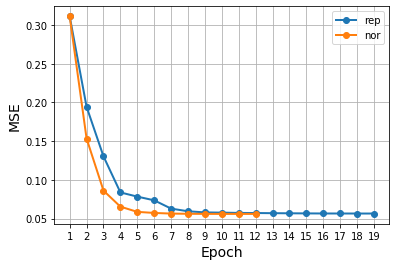

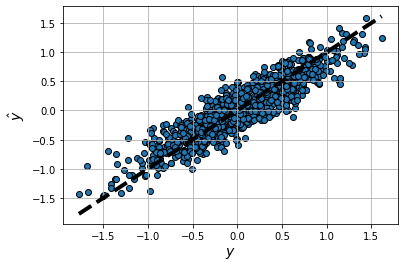

In [257]:
# ---------------- Main for linear regression using Coordinate Descent --------------

np.random.seed(17)
n, d, noise = 1000, 20, 1.0

myeps = 1e-4

[X, u, y] = gimme_data_regres(n, d, noise)
print(X)

mse_list = []
[wr, mse_r] = linear_regression_cd(X, y, eps=myeps)
mse_list.append(mse_r)

[wn, mse_n] = linear_regression_cd(X, y, eps=myeps, replace=0)
mse_list.append(mse_n)

loss_plotter(mse_list, 'MSE')
loss_scatter(X, y, wn, 'True vs. Predicted Outcome')